#Detroit blight project

In [27]:
import pandas as pd
import numpy as np
import csv
import sys
import datetime, math
import random
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.externals.six import StringIO
from sklearn.preprocessing import scale
from sklearn import svm
import pydotplus
from IPython.display import Image


I have started by loading all the libraries I will need for this project.

In [28]:
print('Python version ' + sys.version)
print('Pandas version: ' + pd.__version__)

Python version 3.6.0 |Anaconda 4.3.1 (x86_64)| (default, Dec 23 2016, 13:19:00) 
[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]
Pandas version: 0.19.2


I define now some functions that will help me with my calculations. One for estimating the distance between two geographical points, an object to store information about each building I find, and a function to compare times of events.

In [ ]:
def dist_pts(point1,point2):
#calculates distance between 2 latitude&longitude coordinates using ‘haversine’ formula

#earth radius
   earth_r = 6371E03
    
   point1r =[0,0]
   point2r =[0,0]
   for i in range(len(point1)):
     point1r[i] = float(point1[i])/360.0*2*math.pi
   for i in range(len(point2)):
     point2r[i] = float(point2[i])/360.0*2*math.pi
   delta_lat = abs(point1r[0] -point2r[0])
   delta_lon = abs(point1r[1] - point2r[1])
   a_val = math.sin(delta_lat/2)**2 + math.cos(point1r[0])*math.cos(point2r[0])*math.sin(delta_lon/2)**2
   c_val = 2*math.atan2((a_val)**(0.5),(1.0 - a_val)**(0.5))
   dist = earth_r*c_val
   return dist

class Build_description:
#Stores latitude, longitude and time of event happening at a building
  def __init__(self,input_coordinates,input_date):
    self.latitude = input_coordinates[0]
    self.longitude = input_coordinates[1]
    self.year = input_date[2]
    self.month = input_date[0]
    self.day = input_date[1]

def date_compare(date_building,date_violation):
#Compares dates between two events happening at a building (most of the time one of the events
#will be the demolition of it
    index_date = "N"
    year_building = int(date_building[2]) + 2000
    day_building = int(date_building[1])
    month_building = int(date_building[0])
    month_violation = int(date_violation[0])
    day_violation = int(date_violation[1])
    year_violation = int(date_violation[2])
    if (year_violation < year_building):
      index_date = "Y"
    elif (year_violation == year_building and month_violation < month_building):
      index_date = "Y"
    elif (year_violation == year_building and month_violation == month_building and day_violation <= day_building):
      index_date = "Y"
    return index_date

The datasets require a bit of tidying up. Some geocoordinates are missing or way off, and some dates are weird. So, I'm filtering out rows corresponding to some odd values, and providing reasonable values in cases where I can make plausible assumptions.

In [30]:
# Tidying up detroit-crime.csv file
crime_df = pd.read_csv('detroit-crime.csv',dayfirst=False)
# Extract date from INCIDENTDATE field
date_raw = crime_df["INCIDENTDATE"].apply(lambda x: x.split(" "))
year = []
for item in date_raw:
  year.append(item[0])
crime_df["date_clean"] = pd.Series(year)
# Filter out empty geocoordinate fields
crime_df["LAT"].fillna('')
crime_df = crime_df.dropna(subset=["LAT"])
# Filter out dates from 2017 and beyond, as the file is supposed to contain data until 2016
crime_df_clean = crime_df[pd.to_datetime(crime_df["date_clean"]) < datetime.date(2017,1,1)]

In [31]:
#Clean blight violation file
blight_df = pd.read_csv('detroit-blight-violations.csv', dayfirst=False)
# Extract date from INCIDENTDATE field
date_raw = blight_df["TicketIssuedDT"].apply(lambda x: x.split(" "))
year_bl = []
for item in date_raw:
  day,month,year = item[0].split("/")
#some records have strange date formats, which I'm transforming into 2017 records to filter them out later
  if (int(year) >2017):
        item[0] = "01/01/2017"
  year_bl.append(item[0])
blight_df["date_clean"] = pd.Series(year_bl)


In [32]:
# Filter out empty geocoordinate fields
position_lat = []
position_lon = []
blight_df["ViolationAddress"].fillna('')
blight_df = blight_df.dropna(subset=["ViolationAddress"])
position_raw = blight_df["ViolationAddress"].apply(lambda x: x.split("("))

In [33]:
for item in position_raw:
    item[1] = item[1][:-1]
    position_blight = item[1].split(',')
    position_lat.append(position_blight[0])
    position_lon.append(position_blight[1])


In [34]:
blight_df["latitude_clean"] = pd.Series(position_lat)
blight_df["longitude_clean"] = pd.Series(position_lon)


In [35]:
# Filter out dates from 2017 and beyond, as the file is supposed to contain data until 2016
blight_df_clean = blight_df[pd.to_datetime(blight_df["date_clean"]) < datetime.date(2017,1,1)]
blight_df_clean = blight_df_clean[blight_df_clean["latitude_clean"].astype(float) < 50.0]

In [36]:
#Cleaning up file detroit-311.csv
d311_df = pd.read_csv('detroit-311.csv',dayfirst=False)
# Extract date from "ticket_created_date_time" field
date_raw = d311_df["ticket_created_date_time"].apply(lambda x: x.split(" "))
year_311 = []
for item in date_raw:
  day,month,year = item[0].split("/")
  if (int(year) >2017):
        item[0] = "01/01/2017"
  year_311.append(item[0])
d311_df["date_clean"] = pd.Series(year_311)
# Filter out empty geocoordinate fields and weird longitude values
d311_df["lat"].fillna('')
d311_df = d311_df.dropna(subset=["lat"])
d311_df = d311_df[d311_df["lng"] < 50.0]
# Filter out dates from 2017 and beyond, as the file is supposed to contain data until 2016
d311_df_clean = d311_df[pd.to_datetime(d311_df["date_clean"]) < datetime.date(2017,1,1)]

In [37]:
#Cleaning up file detroit-demolition-permits.tsv
df_demo = pd.read_csv('detroit-demolition-permits.tsv',sep='\t',dayfirst=False)
df_demo["site_location"].fillna('')
df_demo = df_demo.dropna(subset=["site_location"])
date_raw = df_demo["PERMIT_APPLIED"].apply(lambda x: x.split("/"))
year_demo = []
for item in date_raw:
#Some dates have big numbers for the year. I substitute them for "2017", then will filter out all dates beyond 2016
    if (int(item[2]) >2017):
        item[2] = "2017"
    newdate = item[0] +"/" + item[1] + "/" + item[2]
    year_demo.append(newdate)
df_demo["date_clean"] = pd.Series(year_demo)
# Filter out dates from 2017 and beyond, as the file is supposed to contain data until 2016
df_demo_clean = df_demo[pd.to_datetime(df_demo["date_clean"]) < datetime.date(2017,1,1)]

Now that all files have been loaded into dataframes and cleaned, I build a list of buildings. First, I include geocoordinates for all the events found in all the event files.

In [38]:
#Create temporary building list from blight violation file

position_blight = []
latitude_blight = blight_df_clean["latitude_clean"].tolist()
longitude_blight = blight_df_clean["longitude_clean"].tolist()

for i in range(len(latitude_blight)):
    position_blight.append([latitude_blight[i],longitude_blight[i]])
      
#Check for repeated buildings                          
builds = []
for item in position_blight:
    if (item not in builds):
        builds.append(item)
  
                             

In [39]:
#Adding buildings from crime file

position_crime = []
latitude_crime = crime_df_clean["LAT"].tolist()
longitude_crime = crime_df_clean["LON"].tolist()

for i in range(len(latitude_crime)):
    position_crime.append([latitude_crime[i],longitude_crime[i]])
      
#Check for repeated buildings                          
for item in position_crime:
    if (item not in builds):
        builds.append(item)

In [40]:
#Adding buildings from 311 file

position_311 = []
latitude_311 = d311_df_clean["lat"].tolist()
longitude_311 = d311_df_clean["lng"].tolist()

for i in range(len(latitude_311)):
    position_311.append([latitude_311[i],longitude_311[i]])
      
#Check for repeated buildings                          
for item in position_311:
    if (item not in builds):
        builds.append(item)

Now, I try to compact the list finding buildings that are repeated across files. Inspection of the Detroit map makes me think that the typical building has a diameter of about 6m, so any events happening inside the same 6m bubble correspond to the same building. With this simplification, I obtain a large file of buildings.

In [41]:
#GPS coordinates within 3m of each other correspond to the same building
for index_loc in range(len(builds) - 1):
  for index_loc2 in range(index_loc+1,len(builds)):
    dist_ab = dist_pts(builds[index_loc],builds[index_loc2])
    if (dist_ab <= 3):
      builds[index_loc2][0] = builds[index_loc][0]
      builds[index_loc2][1] = builds[index_loc][1]
      
#check for repeats again
builds_final = []
for item in builds:
  if (item not in builds_final):
    builds_final.append(item)

In [42]:
header = ['Latitude','Longitude']
output_builds = open('list_buildings.csv', "w", newline='')
writer = csv.writer(output_builds,delimiter=',')
writer.writerow(header)
#Write building list in CSV file
for item in builds_final:
  writer.writerow(item) 

output_builds.close()

Once I have a list of buildings, my next step is to locate the buildings that are listed in the demolition permits file, and assign labels of "blighted" or "non-blighted" to these records in order to obtain training and testing sets for my model.

In [46]:

permits = []
viol_type = []
date_type = []


input_blds = open('list_buildings.csv', 'r', newline='')
data_blds = csv.DictReader(input_blds)


header = ['Latitude','Longitude','Label','Date_demolition']
output = open('list_buildings_labeled.csv', "w", newline='')
writer = csv.writer(output,delimiter=',')
writer.writerow(header)

location_raw = df_demo_clean["site_location"]
date_raw = df_demo_clean["PERMIT_APPLIED"].apply(lambda x: x.split("/"))

#Store geocoordinates and demolition date on permit objects
for idx, item in date_raw.iteritems():
  location_tmp = location_raw[idx]
  if ("(" in location_tmp):
    [kk1,posit0] = location_tmp.split("(")
    posit0 = posit0[:-1]
    posit_bld = posit0.split(",")
    building_feats = Build_description(posit_bld,item)
    permits.append(building_feats)

#compare permit objects with list of buildings to assign them labels
kcounter = -1
for line in data_blds:
   bldg_position = [line["Latitude"],line["Longitude"]]
   viol_type.append("non_blighted")
   date_type.append("1/1/17")
   kcounter = kcounter + 1
   for item in permits:
    position_demo = [item.latitude,item.longitude]
    dist_points = dist_pts(bldg_position,position_demo)
    if (dist_points <= 3.0):
      viol_type[kcounter] = "blighted"
      date_type[kcounter] = item.month + "/" + item.day + "/" + item.year

   writer.writerow([bldg_position[0],bldg_position[1],viol_type[kcounter],date_type[kcounter]])




input_blds.close()
output.close()

Creating now a training set. For that, I split by half my list of labeled buildings into a training list and a validation list, with records chosen at random. On each of these sets, half of the records correspond to blighted buildings and the other half correspond to non-blighted buildings.

In [47]:
records_no = []
records_yes = []


input_labels = open('list_buildings_labeled.csv', 'r', newline='')
data_labels = csv.DictReader(input_labels)

output = open('training_sample.csv', "w", newline='')
writer = csv.writer(output,delimiter=',')

#Create lists of blighted and non-blighted buildings, and count size of these lists
count_yes = 0.0
count_no = 0.0
nrecords_yes = 0
nrecords_no = 0
for line in data_labels:
  position =[line["Latitude"],line["Longitude"],line["Label"],line["Date_demolition"]]
  if (line["Label"] == "blighted"):
      records_no.append(position)
      nrecords_no = nrecords_no + 1
  if (line["Label"] == "non_blighted"):
      records_yes.append(position)
      nrecords_yes = nrecords_yes + 1

# Select size of the training set as half the size of the total set, 
# according to the category of building that is in smallest number.
if (nrecords_yes < nrecords_no):
    size_set = int(nrecords_yes/2.0)
    print("size of the set: ", size_set*2)
else:
    size_set = int(nrecords_no/2.0)
    print("size of the set: ", size_set*2)

# Choose records at random for each subset
sample_train_no = random.sample(records_no,size_set)
sample_train_yes = random.sample(records_yes,size_set)

# Repeat process for validation set
sample_test_no = [x for x in records_no if x not in sample_train_no]
sample_test_yes = [x for x in records_yes if x not in sample_train_yes]


header = ["Latitude","Longitude","Label","Date_demolition"]

writer.writerow(header)

for line in sample_train_no:
  writer.writerow(line)
for line in sample_train_yes:
  writer.writerow(line)

input_labels.close()
output.close()

output_test = open('validation_sample.csv', "w", newline='')
writer = csv.writer(output_test,delimiter=',')
writer.writerow(header)

for line in sample_test_no:
  writer.writerow(line)
for line in sample_test_yes:
  writer.writerow(line)

output_test.close()

size of the set:  1982


Now I create the arrays of features for each building. I will include blight violation counts at each building, in the nearest neighbour area and in a radius of 1km to account for the effect of a possible negative influence of the neighbourhood. I will also include crime counts at each building and in a radius of 1km.

In [48]:
input_training = open('training_sample.csv', 'r', newline='')
data_st = csv.DictReader(input_training)

output = open('list_buildings_features_train.csv', "w", newline='')
writer = csv.writer(output,delimiter=',')


violations = [0 for x in range(400000)]
viol_nn = [0 for x in range(400000)]
viol_region = [0 for x in range(400000)]
crimes = [0 for x in range(400000)]
crime_region = [0 for x in range(400000)]
counter_bldg = -1
vector_blight = []
vector_crime = []
array_features = []
array_outcomes = []

vec_titles = ["Latitude","Longitude","Label","Violations","Violations_neighbours",
              "Violations_region","Crimes","Crimes_region"]

writer.writerow(vec_titles)

for idx, line_blight in blight_df_clean.iterrows():
  position_blight = [line_blight['latitude_clean'], line_blight['longitude_clean']]
  date_raw = line_blight["date_clean"].split("/")
  building_feats = Build_description(position_blight,date_raw)
  vector_blight.append(building_feats)
    
for idx, line_crime in crime_df_clean.iterrows():
  position_crime = [line_crime["LAT"], line_crime["LON"]]
  time_raw = line_crime['date_clean']
  time_processed = time_raw.split(" ")
  date_crime = time_processed[0].split("/")
  crime_feats = Build_description(position_crime,date_crime)
  vector_crime.append(crime_feats)
    
for line in data_st:
  counter_bldg = counter_bldg + 1
  position_bldg = [line["Latitude"],line["Longitude"]]
  date_bldg = line["Date_demolition"].split("/")

# blight violation records
  for element in vector_blight:
    kkvector = [element.month,element.day,element.year]
    if (date_compare(date_bldg,[element.month,element.day,element.year]) == "Y"):
      separation = dist_pts(position_bldg,[element.latitude,element.longitude])
# length of typical house: 5-6m. I assume radial extent of 3.0m around each point
      if (separation < 3.0):
        violations[counter_bldg] = violations[counter_bldg] + 1
# consider neighbours at 2 houses distance
      elif (separation >= 3 and separation < 15.0):
        viol_nn[counter_bldg] = viol_nn[counter_bldg] + 1
# consider neighbours in 1km radius (regional)
      elif (separation >= 15.0 and separation < 1000.0):
        viol_region[counter_bldg] = viol_region[counter_bldg] + 1

#crime records
  for element in vector_crime:
    if (date_compare(date_bldg,[element.month,element.day,element.year]) == "Y"):
      separation = dist_pts(position_bldg,[element.latitude,element.longitude])
# length of typical house: 5-6m. I assume radial extent of 3.0m around each point
      if (separation < 3.0):
        crimes[counter_bldg] = crimes[counter_bldg] + 1
# consider larger region (1km)
      elif (separation >= 3 and separation < 1000.0):
        crime_region[counter_bldg] = crime_region[counter_bldg] + 1 

  writer.writerow([line["Latitude"],line["Longitude"],line["Label"],violations[counter_bldg],
  viol_nn[counter_bldg],viol_region[counter_bldg], crimes[counter_bldg], 
  crime_region[counter_bldg]])
  
  array_features.append([line["Latitude"],line["Longitude"],violations[counter_bldg],
  viol_nn[counter_bldg],viol_region[counter_bldg], crimes[counter_bldg], crime_region[counter_bldg]])
  
  array_outcomes.append(line["Label"])

input_training.close()
output.close()

#Same is done for validation set
input_validation = open('validation_sample.csv', 'r', newline='')
data_st = csv.DictReader(input_validation)
output_validation = open('list_buildings_features_validation.csv', "w", newline='')
writer = csv.writer(output_validation,delimiter=',')

violations = [0 for x in range(400000)]
viol_nn = [0 for x in range(400000)]
viol_region = [0 for x in range(400000)]
crimes = [0 for x in range(400000)]
crime_region = [0 for x in range(400000)]
counter_bldg = -1
vector_blight = []
vector_crime = []
array_features_val = []
array_outcomes_val = []

vec_titles = ["Latitude","Longitude","Label","Violations","Violations_neighbours",
              "Violations_region","Crimes","Crimes_region"]
writer.writerow(vec_titles)

for idx, line_blight in blight_df_clean.iterrows():
  position_blight = [line_blight['latitude_clean'], line_blight['longitude_clean']]
  date_raw = line_blight["date_clean"].split("/")
  building_feats = Build_description(position_blight,date_raw)
  vector_blight.append(building_feats)
    
for idx, line_crime in crime_df_clean.iterrows():
  position_crime = [line_crime["LAT"], line_crime["LON"]]
  time_raw = line_crime['date_clean']
  time_processed = time_raw.split(" ")
  date_crime = time_processed[0].split("/")
  crime_feats = Build_description(position_crime,date_crime)
  vector_crime.append(crime_feats)
    
for line in data_st:
  counter_bldg = counter_bldg + 1
  position_bldg = [line["Latitude"],line["Longitude"]]
  date_bldg = line["Date_demolition"].split("/")

# blight violation records
  for element in vector_blight:
    kkvector = [element.month,element.day,element.year]
    if (date_compare(date_bldg,[element.month,element.day,element.year]) == "Y"):
      separation = dist_pts(position_bldg,[element.latitude,element.longitude])
# length of typical house: 5-6m. I assume radial extent of 3.0m around each point
      if (separation < 3.0):
        violations[counter_bldg] = violations[counter_bldg] + 1
# consider neighbours at 2 houses distance
      elif (separation >= 3 and separation < 15.0):
        viol_nn[counter_bldg] = viol_nn[counter_bldg] + 1
# consider neighbours in 1km radius (regional)
      elif (separation >= 15.0 and separation < 1000.0):
        viol_region[counter_bldg] = viol_region[counter_bldg] + 1

#crime records
  for element in vector_crime:
    if (date_compare(date_bldg,[element.month,element.day,element.year]) == "Y"):
      separation = dist_pts(position_bldg,[element.latitude,element.longitude])
# length of typical house: 5-6m. I assume radial extent of 3.0m around each point
      if (separation < 3.0):
        crimes[counter_bldg] = crimes[counter_bldg] + 1
# consider larger region (1km)
      elif (separation >= 3 and separation < 1000.0):
        crime_region[counter_bldg] = crime_region[counter_bldg] + 1 
        
  writer.writerow([line["Latitude"],line["Longitude"],line["Label"],violations[counter_bldg],
  viol_nn[counter_bldg],viol_region[counter_bldg], crimes[counter_bldg], 
  crime_region[counter_bldg]])
  
  array_features_val.append([line["Latitude"],line["Longitude"],violations[counter_bldg],
  viol_nn[counter_bldg],viol_region[counter_bldg], crimes[counter_bldg], crime_region[counter_bldg]])
  
  array_outcomes_val.append(line["Label"])

input_validation.close()
output_validation.close()

With the features constructed for each set, I will train my model. I'll be trying a decision tree, random forest and SVM. I am trying first just the blight violations at each building as feature for the model.

In [50]:
num_events = 0
selected_features = []
selected_features_val = []

#just blight violation events at the building
for item in array_features:
      selected_features.append(float(item[2]))
for item in array_features_val:
    selected_features_val.append(float(item[2]))
      
selected_features_trf = np.array(selected_features)
selected_features_val_trf = np.array(selected_features_val)
array_outcomes_trf = np.array(array_outcomes)
array_outcomes_val_trf = np.array(array_outcomes_val)
#for one-dimensional feature vectors
selected_features_trf = selected_features_trf[:, None]
selected_features_val_trf = selected_features_val_trf[:, None]

#scaling of the features to harmonize them
selected_features_scaled = scale(selected_features_trf)
selected_features_val_scaled = scale(selected_features_val_trf)

clf = tree.DecisionTreeClassifier(max_depth = 5, min_samples_leaf = 5)
rforest = RandomForestClassifier(n_estimators=10)
svmmodel = svm.SVC()
#using my training set
#clf = clf.fit(features_train, outcomes_train)
#prediction = clf.predict([[4.]])
#print(prediction)
#using cross-validation 5
scores = cross_val_score(clf, selected_features_scaled, array_outcomes_trf, cv=5)
print("Accuracy decision tree: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
scores_rdforest = cross_val_score(rforest,selected_features_scaled, array_outcomes_trf, cv=5)
print("Accuracy random forest: %0.2f (+/- %0.2f)" % (scores_rdforest.mean(), scores_rdforest.std() * 2))
scores_svm = cross_val_score(svmmodel,selected_features_scaled, array_outcomes_trf, cv=5)
print("Accuracy SVM: %0.2f (+/- %0.2f)" % (scores_svm.mean(), scores_svm.std() * 2))
clf1 = clf.fit(selected_features_scaled,array_outcomes_trf)
rdforest1 = rforest.fit(selected_features_scaled,array_outcomes_trf)
svm1 = svmmodel.fit(selected_features_scaled,array_outcomes_trf)

#run on validation set
vector_prediction = clf1.predict(selected_features_val_scaled)
vector_rforest = rdforest1.predict(selected_features_val_scaled)
vector_svm = svm1.predict(selected_features_val_scaled)
number_hits = 0
number_hits_rforest = 0
number_hits_svm = 0
for i in range(len(vector_prediction)):
    if (vector_prediction[i] == array_outcomes_val[i]):
      number_hits = number_hits + 1
    if (vector_rforest[i] == array_outcomes_val[i]):
      number_hits_rforest = number_hits_rforest + 1
    if (vector_svm[i] == array_outcomes_val[i]):
      number_hits_svm = number_hits_svm + 1
    
number_hits = number_hits/len(vector_prediction)
number_hits_rforest = number_hits_rforest/len(vector_prediction)
number_hits_svm = number_hits_svm/len(vector_prediction)
print("Accuracy on test set: ", number_hits," (decision tree)",number_hits_rforest," (random forest)", 
      number_hits_svm," (SVM)")

Accuracy decision tree: 0.50 (+/- 0.01)
Accuracy random forest: 0.50 (+/- 0.01)
Accuracy SVM: 0.50 (+/- 0.01)
Accuracy on test set:  0.01070874670736811  (decision tree) 0.010580734103050146  (random forest) 0.010689052460549962  (SVM)


The performance is quite bad, which I think it was expected from the lack of detail of the model. I'm adding more features: blight violations in the area of the building (arbitrarily chosen as 1km), crimes at the building, and crimes in a 1km radius area around the building.

In [51]:
#blight violation events at the building + blight violations around 1km radius 
selected_features_ext = []
selected_features_val_ext = []
for item in array_features:
  selected_features_ext.append([float(item[2]),float(item[4])])
for item in array_features_val:
  selected_features_val_ext.append([float(item[2]),float(item[4])])

selected_features_trf = np.array(selected_features_ext)
selected_features_val_trf = np.array(selected_features_val_ext)
#scaling of the features to harmonize them
selected_features_scaled = scale(selected_features_trf)
selected_features_val_scaled = scale(selected_features_val_trf)

scores = cross_val_score(clf, selected_features_scaled, array_outcomes_trf, cv=5)
print("Accuracy decision tree: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
scores_rdforest = cross_val_score(rforest,selected_features_scaled, array_outcomes_trf, cv=5)
print("Accuracy random forest: %0.2f (+/- %0.2f)" % (scores_rdforest.mean(), scores_rdforest.std() * 2))
scores_svm = cross_val_score(svmmodel,selected_features_scaled, array_outcomes_trf, cv=5)
print("Accuracy SVM: %0.2f (+/- %0.2f)" % (scores_svm.mean(), scores_svm.std() * 2))
clf2 = clf.fit(selected_features_scaled,array_outcomes_trf)
rdforest2 = rforest.fit(selected_features_scaled,array_outcomes_trf)
svm2 = svmmodel.fit(selected_features_scaled,array_outcomes_trf)


#run on validation set
vector_prediction = clf2.predict(selected_features_val_scaled)
vector_rforest = rdforest2.predict(selected_features_val_scaled)
vector_svm = svm2.predict(selected_features_val_scaled)
number_hits = 0
number_hits_rforest = 0
number_hits_svm = 0
for i in range(len(vector_prediction)):
    if (vector_prediction[i] == array_outcomes_val[i]):
      number_hits = number_hits + 1
    if (vector_rforest[i] == array_outcomes_val[i]):
      number_hits_rforest = number_hits_rforest + 1
    if (vector_svm[i] == array_outcomes_val[i]):
      number_hits_svm = number_hits_svm + 1
    
number_hits = number_hits/len(vector_prediction)
number_hits_rforest = number_hits_rforest/len(vector_prediction)
number_hits_svm = number_hits_svm/len(vector_prediction)
print("Accuracy on test set: ", number_hits," (decision tree)",number_hits_rforest," (random forest)", 
      number_hits_svm," (SVM)")

Accuracy decision tree: 0.95 (+/- 0.02)
Accuracy random forest: 0.95 (+/- 0.02)
Accuracy SVM: 0.92 (+/- 0.04)
Accuracy on test set:  0.6407375495433396  (decision tree) 0.6406833903645898  (random forest) 0.5641121587356294  (SVM)


In [52]:
#blight + crime events at the building
selected_features_ext = []
selected_features_val_ext = []
for item in array_features:
      selected_features_ext.append([float(item[2]),float(item[5])])
for item in array_features_val:
  selected_features_val_ext.append([float(item[2]),float(item[5])])

selected_features_trf = np.array(selected_features_ext)
selected_features_val_trf = np.array(selected_features_val_ext)
#scaling of the features to harmonize them
selected_features_scaled = scale(selected_features_trf)
selected_features_val_scaled = scale(selected_features_val_trf)

scores = cross_val_score(clf, selected_features_scaled, array_outcomes_trf, cv=5)
print("Accuracy decision tree: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
scores_rdforest = cross_val_score(rforest,selected_features_scaled, array_outcomes_trf, cv=5)
print("Accuracy random forest: %0.2f (+/- %0.2f)" % (scores_rdforest.mean(), scores_rdforest.std() * 2))
scores_svm = cross_val_score(svmmodel,selected_features_scaled, array_outcomes_trf, cv=5)
print("Accuracy SVM: %0.2f (+/- %0.2f)" % (scores_svm.mean(), scores_svm.std() * 2))
clf3 = clf.fit(selected_features_scaled,array_outcomes_trf)
rdforest3 = rforest.fit(selected_features_scaled,array_outcomes_trf)
svm3 = svmmodel.fit(selected_features_scaled,array_outcomes_trf)

#run on validation set
vector_prediction = clf3.predict(selected_features_val_scaled)
vector_rforest = rdforest3.predict(selected_features_val_scaled)
vector_svm = svm3.predict(selected_features_val_scaled)
number_hits = 0
number_hits_rforest = 0
number_hits_svm = 0
for i in range(len(vector_prediction)):
    if (vector_prediction[i] == array_outcomes_val[i]):
      number_hits = number_hits + 1
    if (vector_rforest[i] == array_outcomes_val[i]):
      number_hits_rforest = number_hits_rforest + 1
    if (vector_svm[i] == array_outcomes_val[i]):
      number_hits_svm = number_hits_svm + 1
    
number_hits = number_hits/len(vector_prediction)
number_hits_rforest = number_hits_rforest/len(vector_prediction)
number_hits_svm = number_hits_svm/len(vector_prediction)
print("Accuracy on test set: ", number_hits," (decision tree)",number_hits_rforest," (random forest)", 
      number_hits_svm," (SVM)")

Accuracy decision tree: 0.50 (+/- 0.01)
Accuracy random forest: 0.51 (+/- 0.01)
Accuracy SVM: 0.51 (+/- 0.01)
Accuracy on test set:  0.015952339922700082  (decision tree) 0.01582432731838212  (random forest) 0.015932645675881933  (SVM)


In [53]:
#blight at the building + crime events in 1km radius
selected_features_ext = []
selected_features_val_ext = []
for item in array_features:
  selected_features_ext.append([float(item[2]),float(item[6])])
for item in array_features_val:
  selected_features_val_ext.append([float(item[2]),float(item[6])])

selected_features_trf = np.array(selected_features_ext)
selected_features_val_trf = np.array(selected_features_val_ext)
#scaling of the features to harmonize them
selected_features_scaled = scale(selected_features_trf)
selected_features_val_scaled = scale(selected_features_val_trf)

scores = cross_val_score(clf, selected_features_scaled, array_outcomes_trf, cv=5)
print("Accuracy decision tree: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
scores_rdforest = cross_val_score(rforest,selected_features_scaled, array_outcomes_trf, cv=5)
print("Accuracy random forest: %0.2f (+/- %0.2f)" % (scores_rdforest.mean(), scores_rdforest.std() * 2))
scores_svm = cross_val_score(svmmodel,selected_features_scaled, array_outcomes_trf, cv=5)
print("Accuracy SVM: %0.2f (+/- %0.2f)" % (scores_svm.mean(), scores_svm.std() * 2))
clf4 = clf.fit(selected_features_scaled,array_outcomes_trf)
rdforest4 = rforest.fit(selected_features_scaled,array_outcomes_trf)
svm4 = svmmodel.fit(selected_features_scaled,array_outcomes_trf)

#run on validation set
vector_prediction = clf4.predict(selected_features_val_scaled)
vector_rforest = rdforest4.predict(selected_features_val_scaled)
vector_svm = svm4.predict(selected_features_val_scaled)
number_hits = 0
number_hits_rforest = 0
number_hits_svm = 0
for i in range(len(vector_prediction)):
    if (vector_prediction[i] == array_outcomes_val[i]):
      number_hits = number_hits + 1
    if (vector_rforest[i] == array_outcomes_val[i]):
      number_hits_rforest = number_hits_rforest + 1
    if (vector_svm[i] == array_outcomes_val[i]):
      number_hits_svm = number_hits_svm + 1
    
number_hits = number_hits/len(vector_prediction)
number_hits_rforest = number_hits_rforest/len(vector_prediction)
number_hits_svm = number_hits_svm/len(vector_prediction)
print("Accuracy on test set: ", number_hits," (decision tree)",number_hits_rforest," (random forest)", 
      number_hits_svm," (SVM)")

Accuracy decision tree: 0.97 (+/- 0.02)
Accuracy random forest: 0.97 (+/- 0.02)
Accuracy SVM: 0.97 (+/- 0.02)
Accuracy on test set:  0.7113020358927649  (decision tree) 0.7125427734423082  (random forest) 0.7126707860466261  (SVM)


In [54]:
#blight at the building + blight & crime events in 1km radius
selected_features_ext = []
selected_features_val_ext = []
for item in array_features:
      selected_features_ext.append([float(item[2]),float(item[4]),float(item[6])])
for item in array_features_val:
  selected_features_val_ext.append([float(item[2]),float(item[4]),float(item[6])])

selected_features_trf = np.array(selected_features_ext)
selected_features_val_trf = np.array(selected_features_val_ext)
#scaling of the features to harmonize them
selected_features_scaled = scale(selected_features_trf)
selected_features_val_scaled = scale(selected_features_val_trf)

scores = cross_val_score(clf, selected_features_scaled, array_outcomes_trf, cv=5)
print("Accuracy decision tree: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
scores_rdforest = cross_val_score(rforest,selected_features_scaled, array_outcomes_trf, cv=5)
print("Accuracy random forest: %0.2f (+/- %0.2f)" % (scores_rdforest.mean(), scores_rdforest.std() * 2))
scores_svm = cross_val_score(svmmodel,selected_features_scaled, array_outcomes_trf, cv=5)
print("Accuracy SVM: %0.2f (+/- %0.2f)" % (scores_svm.mean(), scores_svm.std() * 2))
clf5 = clf.fit(selected_features_scaled,array_outcomes_trf)
rdforest5 = rforest.fit(selected_features_scaled,array_outcomes_trf)
svm5 = svmmodel.fit(selected_features_scaled,array_outcomes_trf)

#run on validation set
vector_prediction = clf5.predict(selected_features_val_scaled)
vector_rforest = rdforest5.predict(selected_features_val_scaled)
vector_svm = svm5.predict(selected_features_val_scaled)
number_hits = 0
number_hits_rforest = 0
number_hits_svm = 0
for i in range(len(vector_prediction)):
    if (vector_prediction[i] == array_outcomes_val[i]):
      number_hits = number_hits + 1
    if (vector_rforest[i] == array_outcomes_val[i]):
      number_hits_rforest = number_hits_rforest + 1
    if (vector_svm[i] == array_outcomes_val[i]):
      number_hits_svm = number_hits_svm + 1
    
number_hits = number_hits/len(vector_prediction)
number_hits_rforest = number_hits_rforest/len(vector_prediction)
number_hits_svm = number_hits_svm/len(vector_prediction)
print("Accuracy on test set: ", number_hits," (decision tree)",number_hits_rforest," (random forest)", 
      number_hits_svm," (SVM)")

Accuracy decision tree: 0.97 (+/- 0.02)
Accuracy random forest: 0.96 (+/- 0.02)
Accuracy SVM: 0.97 (+/- 0.03)
Accuracy on test set:  0.7564461731616652  (decision tree) 0.7122522833017405  (random forest) 0.723817729745698  (SVM)


It turns out that the combination of blight violations at the building plus the amount of blight and crime events in the area gives the best outcome of the possibilities I have explored. This agrees with one of the messages highlighted in the bibliography, which is that events in the area have a high impact on the probability of blighting. From the three machine learning methods I have tried, decision trees have the best score, followed by random forests and SVM. I'm plotting now the decision tree for this model.

In [56]:
with open("blight_tree.dot", 'w') as f:
     f = tree.export_graphviz(clf5, out_file=f)

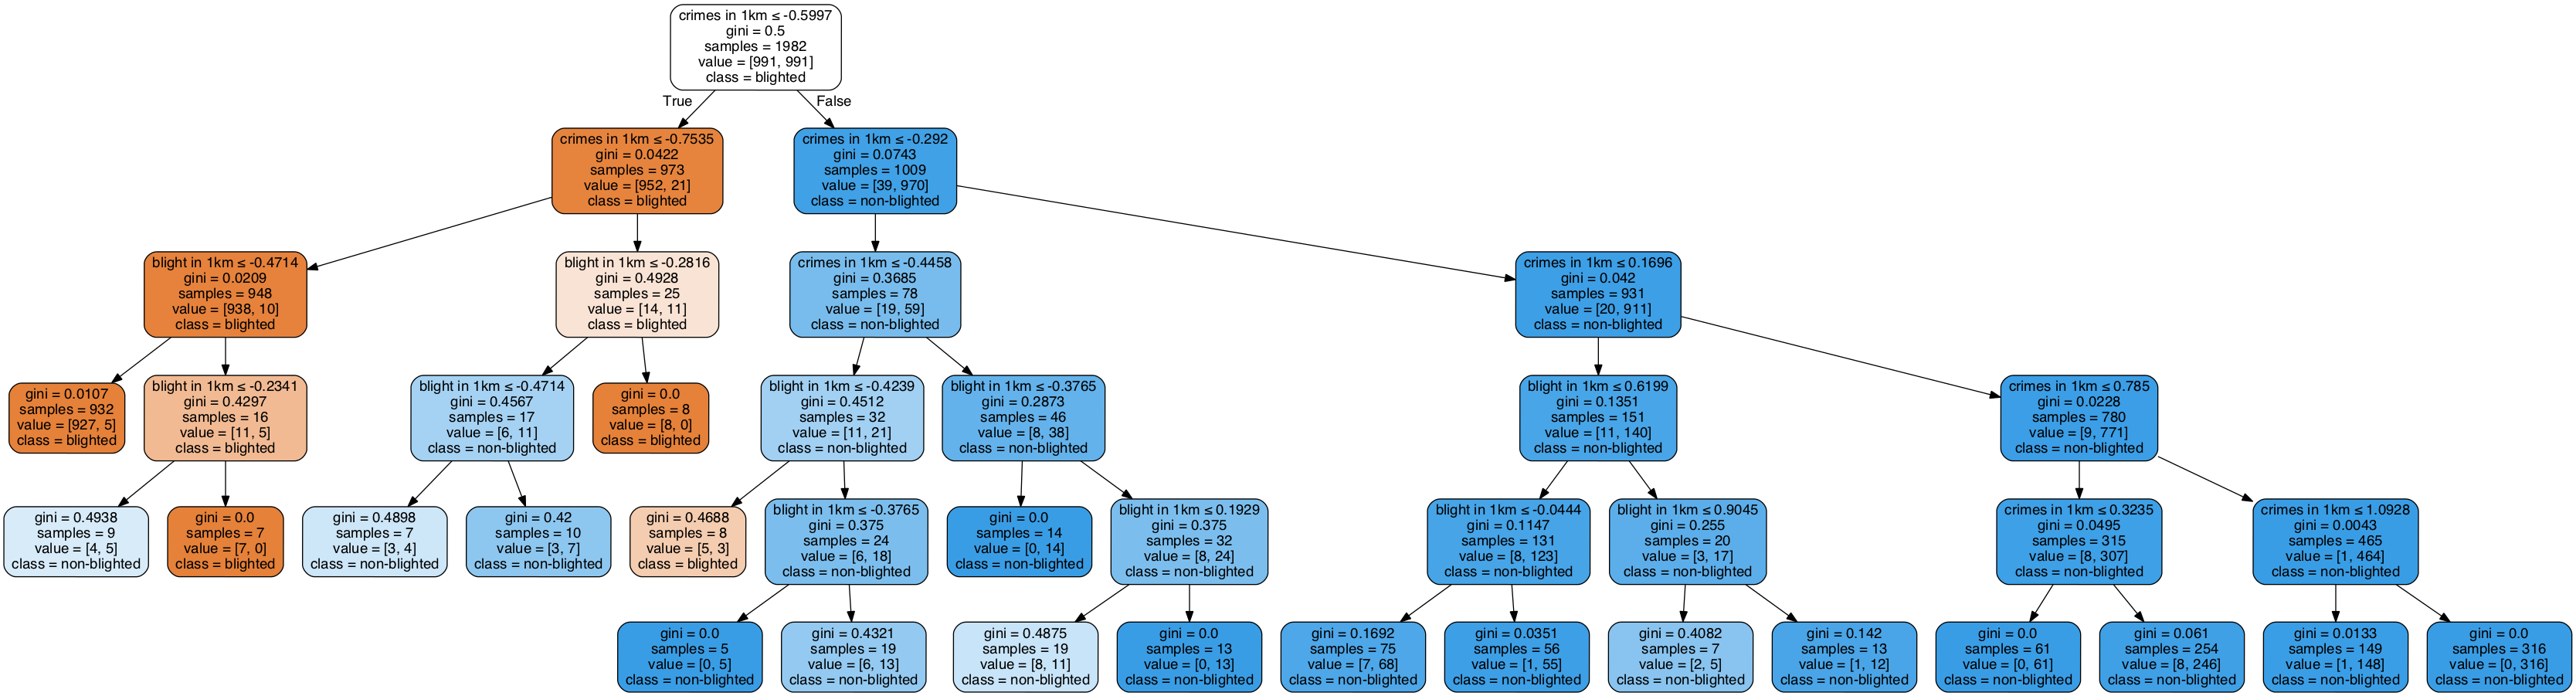

In [58]:
dot_data = tree.export_graphviz(clf5, out_file=None, 
                         feature_names=["blight violations","blight in 1km","crimes in 1km"],  
                         class_names=["blighted","non-blighted"],  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

Inspection of the tree reveals that the main features in relation to the blighting probability of a building are the crime rate and blight violation rate in the area. Therefore, measures to tackle crime and blight violations at a wide level would be beneficial to prevent blighting. Surprisingly, the amount of blight violations in the building has very little effect on the probability of it becoming blighted.

If I had more time, I would explore in more detail several aspects: the definition of building, which was a crude 3m-radius sphere in my model; the definition of neighbouring area, which was arbitrarily chosen by me as 1km, and the effect of socioeconomic variables like income level, number of inhabitants in the building and so on.